In [1]:
import ast
import json
import os
import pickle
import re
import sys
import time
import warnings

import en_core_web_sm
import gensim
import joblib
import nltk
import numpy as np
import pandas as pd
import pymysql
import spacy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import neuralcoref

warnings.filterwarnings('ignore')
from datetime import datetime

from gensim import corpora
from nltk import flatten
from nltk.corpus import wordnet as wn
from nltk.tokenize import sent_tokenize, word_tokenize
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from spacy.symbols import VERB, nsubj
from sqlalchemy import create_engine
from textblob import TextBlob

# stanfordnlp.download('en')
now = datetime.now()
#nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")
neuralcoref.add_to_pipe(nlp)
# stf = stanfordnlp.Pipeline(processors='tokenize,lemma,pos,depparse', treebank='en_ewt', use_gpu=True,
#                            pos_batch_size=3000)  # This sets up a default neural pipeline in English

import re

from nltk.corpus import stopwords

In [2]:
english_stop_words = stopwords.words('english')
REPLACE_NO_SPACE = re.compile(r"(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile(r"(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "
conj_list = ['for', 'or','and','nor','but','yet','so']

In [3]:
def load_file_for_training_classifier(file):
    if len(file) == 0:
        print("Do provide a data file or json file")
    # Converting the  file into a dataframe
    try:
        if file :  # data file
            if (file.endswith('.xlx') or file.endswith('.xlsx')):
                df_input = pd.read_excel(file)
            elif file.endswith('.csv'):
                df_input = pd.read_csv(file)
            elif (file.endswith('.txt') or file.endswith('.json')):
                with open(file) as json_file:
                    data = json.load(json_file)
                    df_input = pd.DataFrame.from_dict(data, orient='columns')

        df_input = df_input.drop(df_input.index[df_input['Rating'] == 'Rating'])
        df_input.astype({'Rating': 'float'}).dtypes
        if 'RepuGen Review' in df_input.columns:
            df_input = df_input.rename(columns={"RepuGen Review": "Comment"})
        elif 'Review' in df_input.columns:
            df_input = df_input.rename(columns={"Review": "Comment"})
        return df_input

    except Exception as e:
        return "error"

<AxesSubplot:xlabel='Speciality', ylabel='count'>

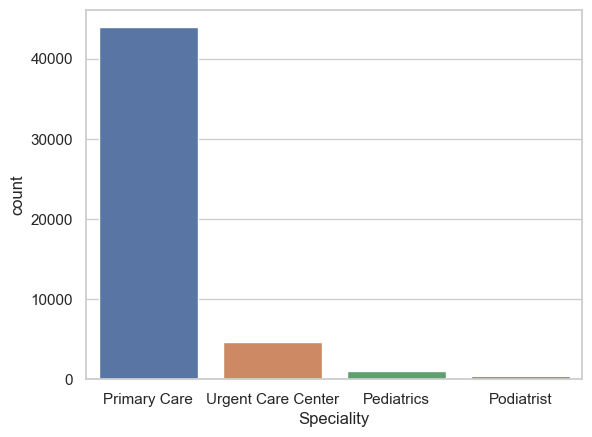

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid")
file = "RepuGenAllData.xlsx"
data = load_file_for_training_classifier(file)

df = pd.DataFrame(data)
sns.countplot(x = df["Speciality"])

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
 
# Read CSV into pandas
file = "RepuGenAllData.xlsx"
data = load_file_for_training_classifier(file)

df = pd.DataFrame(data)
 
name = df['Speciality']
# price = df['price'].head(12)
 
# Figure Size
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
plt.bar(name)
 
# Show Plot
plt.show()

TypeError: bar() missing 1 required positional argument: 'height'

<Figure size 1000x700 with 0 Axes>

In [4]:
def data_preprocessing(comment):
    removed_stop_words = []

    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in comment]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in comment]

    for review in reviews:
        removed_stop_words.append(' '.join([word for word in review.split() if word not in english_stop_words]))

    return removed_stop_words

In [5]:
def classfying_train_lables(df):
    df.loc[df['Rating'] < 5, 'Rating'] = 0
    df.loc[(df['Rating'] > 4) & (df['Rating'] < 8), 'Rating'] = 1
    df.loc[df['Rating'] > 7, 'Rating'] = 2
    df['Rating'] = df['Rating'].astype(str)

    df['Rating'] = df['Rating'].replace(str(0), 'Negative')
    df['Rating'] = df['Rating'].replace(str(1), 'Neutral')
    df['Rating'] = df['Rating'].replace(str(2), 'Positive')
    return df['Rating']

In [20]:
def train_classifier(file):
    df = load_file_for_training_classifier(file)
    if "error" in df:
        return {"Error:":"File format incorrect"}

    df['Comment'] = df['Comment'].astype(str)
    df['Comment'] = data_preprocessing(df['Comment'])
    df['Rating'] = classfying_train_lables(df)

    # ncount vectorizer - vectorizes the words into bigrams
    ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(2, 2))
    ngram_vectorizer.fit(df['Comment'])
    # print(ngram_vectorizer.shape)
    vectorizer_filename = 'vectorizer' + str(now) + '.pkl'
    #vectorizer_filename = 'vectorizer' + '.pkl'
    # joblib.dump(ngram_vectorizer, '/upload/' + vectorizer_filename)

    X = ngram_vectorizer.transform(df['Comment'])
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, df['Rating'], train_size=0.8)

    # # maximum_acc = 0
    # # hyper_parameter = 0
    # # # finding the best hyper parameter
    # # for c in [0.01, 0.05, 0.25, 0.5, 1]:
    # #     svm = LinearSVC(C=c)
    # #     svm.fit(X_train, y_train)
    # #     if accuracy_score(y_test, svm.predict(X_test)) > maximum_acc:
    # #         maximum_acc = accuracy_score(y_test, svm.predict(X_test))
    # #         hyper_parameter = c
    # # y_predict = svm.predict(X_test)

    # final_count_ngram = LinearSVC(C=0.75)
    # final_count_ngram.fit(X, df['Rating'])
    # Y_predict = final_count_ngram.predict(X_test)
    # report = classification_report(y_test, Y_predict)
    
    # print('SVM Accuracy:', accuracy_score(y_test,Y_predict))
    # print(report)

    # # score_dict = {'Vectorizer_filename': vectorizer_filename, 'Classifier_model_name': filename,
    # #               'Max Accuracy is': accuracy_score(y_test, final_count_ngram.predict(X_test))}
    # # # joblib.dump(svm, './upload/' + filename)

    # conf_mat = confusion_matrix(y_test, Y_predict, normalize="true")
    # # Plot the confusion matrix
    # print(conf_mat)
    # sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis" ,xticklabels=['Negative','Neutral','Positive'], yticklabels= ['Negative','Neutral','Positive'])
    # plt.xlabel("True label")
    # plt.ylabel("Predicted label")
    
    return# score_dict


In [19]:
file = "RepuGenAllData.xlsx"
var = train_classifier(file)

(500,)


SVM Accuracy: 0.999
              precision    recall  f1-score   support

    Negative       1.00      0.99      0.99       199
     Neutral       1.00      0.96      0.98       210
    Positive       1.00      1.00      1.00      9591

    accuracy                           1.00     10000
   macro avg       1.00      0.98      0.99     10000
weighted avg       1.00      1.00      1.00     10000

[[0.98994975 0.         0.01005025]
 [0.         0.96190476 0.03809524]
 [0.         0.         1.        ]]


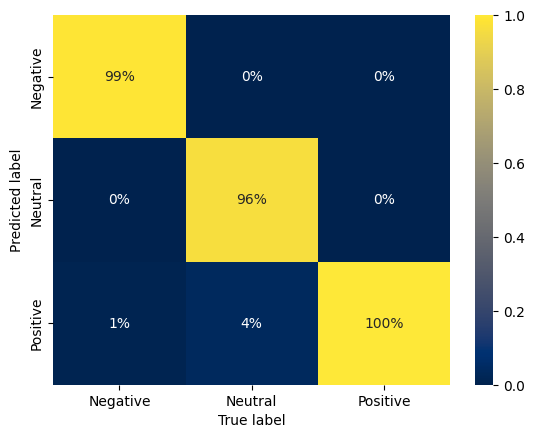

In [56]:
file = "RepuGenAllData.xlsx"
var = train_classifier(file)

In [42]:
def rf_classifier(file):
    df = load_file_for_training_classifier(file)
    if "error" in df:
        return {"Error:":"File format incorrect"}

    df['Comment'] = df['Comment'].astype(str)
    df['Comment'] = data_preprocessing(df['Comment'])
    df['Rating'] = classfying_train_lables(df)

    dfc = df['Comment'][0:1000]
    dfr = df['Rating'][:1000]
    # print(dff)
    # ncount vectorizer - vectorizes the words into bigrams
    ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(2, 2))
    ngram_vectorizer.fit(dfc)
    vectorizer_filename = 'vectorizer' + str(now) + '.pkl'

    X = ngram_vectorizer.transform(dfc)
    X_train, X_test, y_train, y_test = train_test_split(
        X, dfr, train_size=0.8)

    randfor_classifier = RandomForestClassifier()
    randfor_classifier.fit(X,dfr)
    Y_predict = randfor_classifier.predict(X_test)
    report = classification_report(y_test, Y_predict)
    
    print('Random Forest Accuracy:', accuracy_score(y_test,Y_predict))
    print(report)

    conf_mat = confusion_matrix(y_test, Y_predict, normalize="true")
    # Plot the confusion matrix
    print(conf_mat)
    sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis" ,xticklabels=['Negative','Neutral','Positive'], yticklabels= ['Negative','Neutral','Positive'])
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    return# score_dict


Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         1
     Neutral       1.00      1.00      1.00         3
    Positive       1.00      1.00      1.00       196

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


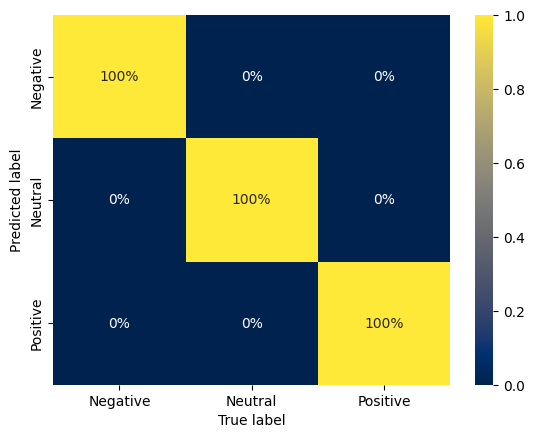

In [43]:
file = "RepuGenAllData.xlsx"
var = rf_classifier(file)

In [22]:
# Apply tfidf and chi2 for Feature Extraction
def tfidf_chi2_classifier(file):
    df = load_file_for_training_classifier(file)
    if "error" in df:
        return {"Error:":"File format incorrect"}

    df['Comment'] = df['Comment'].astype(str)
    df['Comment'] = data_preprocessing(df['Comment'])
    df['Rating'] = classfying_train_lables(df)

    tfidfvectorizer = TfidfVectorizer()
    x = tfidfvectorizer.fit_transform(df['Comment'])
    #save the tfidf model as pkl file
    filename = 'vectorizer.pkl'
    # joblib.dump(tfidfvectorizer, filename)
    # print(df.columns.values)
    y = df['Rating']
    # top vocabularies in the data
    vocabulary = tfidfvectorizer.get_feature_names()
    # Apply chi2 to extract the top features
    sel = SelectKBest(k=x.shape[1],score_func=chi2)
    x_new = sel.fit_transform(x,y)
    score = list(sel.scores_)
    p_val = list(sel.pvalues_)
    # co = list(df2.columns.values)b
    data_score = pd.DataFrame({'Column Names':vocabulary,'Chi square score':score,'p_val':p_val})
    # yield data_score
    return x_new, y, data_score

In [49]:
# Create a Mulinomial NaiveBayes classifier
def MNB_classifier(x_new, y):
    X_train,X_test,Y_train,Y_test = train_test_split(x_new, y, test_size=0.2)
    #initialize the classifier
    clf = MultinomialNB()
    #fit the model
    clf.fit(X_train, Y_train)

    Y_predict = clf.predict(X_test)
#     print(Y_predict)
    score_dict = {"Accuracy": accuracy_score(Y_test,Y_predict)}
    report = classification_report(Y_test, Y_predict)
    # conf_mat = confusion_matrix(Y_test, Y_predict)
    print("Mulinomial NaiveBayes Accuracy:",score_dict["Accuracy"])
    print("Report:", report)
    


    # Create the confusion matrix
    conf_mat = confusion_matrix(Y_test, Y_predict, normalize="true")
    # Plot the confusion matrix
    print("conf mat:",conf_mat)
    sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis",xticklabels=['Negative','Neutral','Positive'], yticklabels= ['Negative','Neutral','Positive'])
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    # return score_dict, report
    return


Mulinomial NaiveBayes Accuracy: 0.9591
Report:               precision    recall  f1-score   support

    Negative       1.00      0.04      0.07       198
     Neutral       0.00      0.00      0.00       213
    Positive       0.96      1.00      0.98      9589

    accuracy                           0.96     10000
   macro avg       0.65      0.34      0.35     10000
weighted avg       0.94      0.96      0.94     10000

conf mat: [[3.53535354e-02 5.05050505e-03 9.59595960e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 5.21430806e-04 9.99478569e-01]]


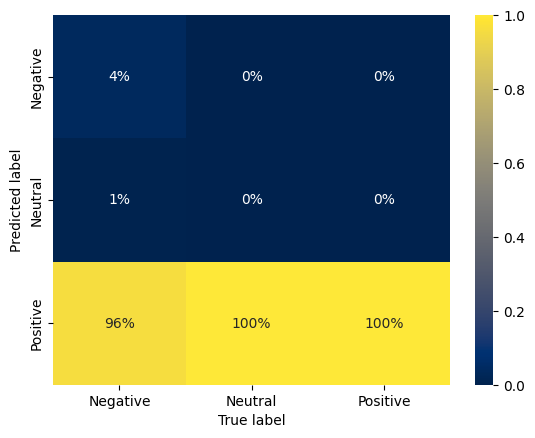

In [50]:
file = "RepuGenAllData.xlsx"
x_new, y, data_score = tfidf_chi2_classifier(file)
# score_dict, report = 
MNB_classifier(x_new, y)